# Notebook for training a ML algorithm to predict attractants / repellents for _E. coli_

## PART 1: Data pre-processing

### Loading and exploring the chemoeffectors.csv dataset

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

from tools import name2smiles
from tools import add_fingerprints
from tools import add_descriptors

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D

In [3]:
# Variables
file= 'data/chemoeffectors.csv'
smiles_file='data/chemoeffectors_smiles_clean.csv'
smiles_column='Iso_SMILES' # SMILES to used to convert into RDKit molecules
fp_style='rdkit' # Fingerprint style to use for the ML model
nBits=512 # Number of bits generated for the fingerprints
save=True

In [4]:
df = pd.read_csv(file)
df

,Chemoeffectors,Response,Ref_DOI
0,N-acetyl-L-aspartate,attractant,10.1128/jb.112.1.315-326.1972
1,N-acetyl-L-serine,attractant,10.1128/jb.112.1.315-326.1972
2,Beta-alanine,none,10.1128/jb.112.1.315-326.1972
3,L-alpha-Aminoadipate,none,10.1128/jb.112.1.315-326.1972
4,L-alpha-amino-n-butyrate,attractant,10.1128/jb.112.1.315-326.1972
...,...,...,...
361,dopamine,attractant,10.1038/s41396-018-0227-5
362,epinephrine,none,10.1038/s41396-018-0227-5
363,norepinephrine,repellent,10.1038/s41396-018-0227-5
364,"3,4-dihydroxymandelic acid",attractant,10.1038/s41396-018-0227-5


The dataframe consists of chemoeffector names and the response trigerred by these chemoeffectors to _E. coli_. <br>
Let's look at the distribution of attractants and repellents

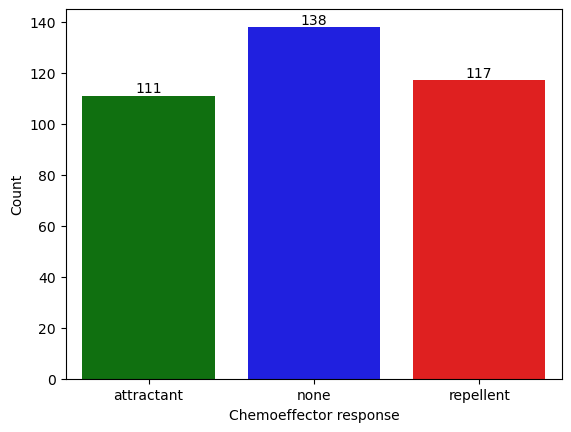

In [5]:
fig, ax = plt.subplots()
ax = sns.countplot(data=df, x='Response', hue='Response', legend=False, palette=['green','blue','red'], stat='count')
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlabel('Chemoeffector response')
ax.set_ylabel('Count')
plt.show()

We don't need the Ref_DOI column

In [6]:
df.drop('Ref_DOI', axis=1, inplace=True)
df.head()

,Chemoeffectors,Response
0,N-acetyl-L-aspartate,attractant
1,N-acetyl-L-serine,attractant
2,Beta-alanine,none
3,L-alpha-Aminoadipate,none
4,L-alpha-amino-n-butyrate,attractant


We will use molecular descriptors and fingerprints to train the ML model. <br>
Molecular descriptors are a set of chemical properties describing a specific molecule. <br>
Molecular fingerprints are binary information of molecular features (or fragments) of the molecule. <br>
To get either of those, the name of the chemical has to be translated into SMILES first.

### Generating SMILES corresponding to the chemoeffectors

In [7]:
# Converting names and adding SMILES to the data frame
smiles = [name2smiles(chemical) for chemical in tqdm(df['Chemoeffectors'])]

df['SMILES']=smiles

df

100%|██████████████████████████████████████████████████████████████| 366/366 [02:50<00:00,  2.15it/s]


,Chemoeffectors,Response,SMILES
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O
2,Beta-alanine,none,C(CN)C(=O)O
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O
4,L-alpha-amino-n-butyrate,attractant,CCC(C(=O)[O-])[NH3+]
...,...,...,...
361,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O
362,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O
363,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O
364,"3,4-dihydroxymandelic acid",attractant,C1=CC(=C(C=C1C(C(=O)O)O)O)O


In [8]:
# Count number of translation fails
nan_count = df['SMILES'].isnull().sum() 
print(f'There are {nan_count} missing SMILES')

There are 54 missing SMILES


The translation can also be done with the isomeric SMILES instead of the canonical ones:

In [9]:
#iso_smiles = [name2smiles(chemical, isomeric=True) for chemical in tqdm(df['Chemoeffectors'])]

df['Iso_SMILES']=df['Chemoeffectors'].progress_apply(lambda x: name2smiles(x, isomeric=True))

df

100%|██████████████████████████████████████████████████████████████| 366/366 [02:47<00:00,  2.18it/s]


,Chemoeffectors,Response,SMILES,Iso_SMILES
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O
4,L-alpha-amino-n-butyrate,attractant,CCC(C(=O)[O-])[NH3+],CC[C@@H](C(=O)[O-])[NH3+]
...,...,...,...,...
361,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O
362,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O
363,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O
364,"3,4-dihydroxymandelic acid",attractant,C1=CC(=C(C=C1C(C(=O)O)O)O)O,C1=CC(=C(C=C1C(C(=O)O)O)O)O


In [10]:
# Count number of translation fails
nan_count = df['Iso_SMILES'].isnull().sum()
print(f'There are {nan_count} missing SMILES')

There are 53 missing SMILES


As you can see, there are missing SMILES from the translation. <br>
We can remove them from the dataframe:

If needed, we can save the dataframe with the missing smiles so they could be added manually.

In [11]:
if save:
    df.to_csv('data/chemoeffectors_smiles.csv', index=False)

We can also "clean" the dataframe by removing the missing smiles

In [12]:
df_clean = df.dropna(ignore_index=True)
if save:
    df_clean.to_csv('data/chemoeffectors_smiles_clean.csv',index=False)
df_clean

,Chemoeffectors,Response,SMILES,Iso_SMILES
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O
4,L-alpha-amino-n-butyrate,attractant,CCC(C(=O)[O-])[NH3+],CC[C@@H](C(=O)[O-])[NH3+]
...,...,...,...,...
307,putrescine,none,C(CCN)CN,C(CCN)CN
308,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O
309,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O
310,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O


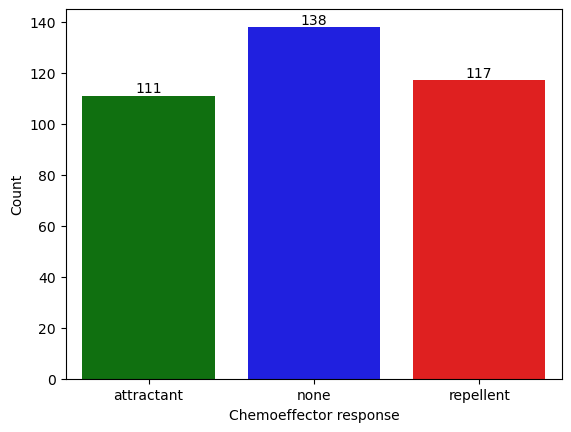

In [13]:
fig, ax = plt.subplots()
ax = sns.countplot(data=df, x='Response', hue='Response', legend=False, palette=['green','blue','red'], stat='count')
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlabel('Chemoeffector response')
ax.set_ylabel('Count')
plt.show()

## Generating inputs features from SMILES

In [14]:
df = pd.read_csv(smiles_file)
df

,Chemoeffectors,Response,SMILES,Iso_SMILES
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O
4,L-alpha-amino-n-butyrate,attractant,CCC(C(=O)[O-])[NH3+],CC[C@@H](C(=O)[O-])[NH3+]
...,...,...,...,...
307,putrescine,none,C(CCN)CN,C(CCN)CN
308,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O
309,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O
310,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O


Now, let's check if there are any duplicates in the SMILES. <br>
Let's start with the canonical SMILES.

In [15]:
print(f"There are {df.duplicated('SMILES', keep=False).sum()} canonical duplicates")
df_can_dup = df.loc[df.duplicated('SMILES', keep=False),:]
df_can_dup

There are 102 canonical duplicates


,Chemoeffectors,Response,SMILES,Iso_SMILES
4,L-alpha-amino-n-butyrate,attractant,CCC(C(=O)[O-])[NH3+],CC[C@@H](C(=O)[O-])[NH3+]
9,D-aspartate,attractant,C(C(C(=O)O)N)C(=O)O,C([C@H](C(=O)O)N)C(=O)O
10,L-aspartate,attractant,C(C(C(=O)O)N)C(=O)O,C([C@@H](C(=O)O)N)C(=O)O
13,formate,none,C(=O)[O-],C(=O)[O-]
16,DL-glycerate,none,C(C(C(=O)O)O)O,C(C(C(=O)O)O)O
...,...,...,...,...
258,2-propanethiol,repellent,CC(C)S,CC(C)S
268,D-ribitol,none,C(C(C(C(CO)O)O)O)O,C([C@H](C([C@H](CO)O)O)O)O
274,cAMP,none,C1C2C(C(C(O2)N3C=NC4=C(N=CN=C43)N)O)OP(=O)(O1)O,C1[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=NC4=C(N=CN=...
275,glycerol,repellent,C(C(CO)O)O,C(C(CO)O)O


Now, the isomeric SMILES.

In [16]:
print(f"There are {df.duplicated('Iso_SMILES', keep=False).sum()} isomeric duplicates")
df_iso_dup = df.loc[df.duplicated('Iso_SMILES', keep=False),:]
df_iso_dup

There are 56 isomeric duplicates


,Chemoeffectors,Response,SMILES,Iso_SMILES
4,L-alpha-amino-n-butyrate,attractant,CCC(C(=O)[O-])[NH3+],CC[C@@H](C(=O)[O-])[NH3+]
10,L-aspartate,attractant,C(C(C(=O)O)N)C(=O)O,C([C@@H](C(=O)O)N)C(=O)O
13,formate,none,C(=O)[O-],C(=O)[O-]
16,DL-glycerate,none,C(C(C(=O)O)O)O,C(C(C(=O)O)O)O
24,DL-lactate,none,CC(C(=O)[O-])O,CC(C(=O)[O-])O
34,propionate,none,CCC(=O)[O-],CCC(=O)[O-]
37,L-serine,attractant,C(C(C(=O)O)N)O,C([C@@H](C(=O)O)N)O
41,L-aspartate,attractant,C(C(C(=O)O)N)C(=O)O,C([C@@H](C(=O)O)N)C(=O)O
42,L-serine,attractant,C(C(C(=O)O)N)O,C([C@@H](C(=O)O)N)O
51,L-isoleucine,repellent,CCC(C)C(C(=O)O)N,CC[C@H](C)[C@@H](C(=O)O)N


In [17]:
diff = df.duplicated('SMILES', keep=False).sum() - df.duplicated('Iso_SMILES', keep=False).sum()
print(f'There are {diff} more duplicates using the canonical SMILES compared to the isomeric SMILES')

There are 46 more duplicates using the canonical SMILES compared to the isomeric SMILES


As we can see, there are more canonical duplicates than isomeric ones. This was expected as both L and D amino acids are present in the data frame for example. If each duplicates had the same response, we could keep the canonical SMILES only to avoid feeding identical inputs in the ML model. However, this is not the case, so the isomeric SMILES will be used.

NOTE: As some coumponds might have different responses depending on the study, we need to check the duplicates.

In [18]:
diff_resp = []
for smile in df_iso_dup['Iso_SMILES'].unique():
    name = df_iso_dup.loc[df_iso_dup['Iso_SMILES'] == smile]['Chemoeffectors'].values[0]
    # print(name)
    responses = df_iso_dup.loc[df_iso_dup['Iso_SMILES'] == smile]['Response'].values
    # print(responses)
    for response in responses:
        if response != responses[0] and name not in diff_resp:
            diff_resp.append(name)
diff_resp

['L-alpha-amino-n-butyrate',
 'propionate',
 'glycerol',
 'cyclic adenosine monophosphate']

As we can see, some chemoeffectors have been assigned different responses. We can drop them to avoid ambiguity.

In [19]:
for name in diff_resp:
    smile = df.loc[df['Chemoeffectors'] == name]['Iso_SMILES'].values[0]
    df = df[df['Iso_SMILES'] != smile].reset_index(drop=True)
df

,Chemoeffectors,Response,SMILES,Iso_SMILES
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+]
...,...,...,...,...
299,putrescine,none,C(CCN)CN,C(CCN)CN
300,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O
301,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O
302,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O


In [20]:
df.drop_duplicates(smiles_column, ignore_index=True, inplace=True)
data = df.copy()
data

,Chemoeffectors,Response,SMILES,Iso_SMILES
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+]
...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O


In [21]:
if save:
    data.to_csv('data/chemoeffectors_ml_smiles.csv',index=False)

Let's check the frequency plot once again

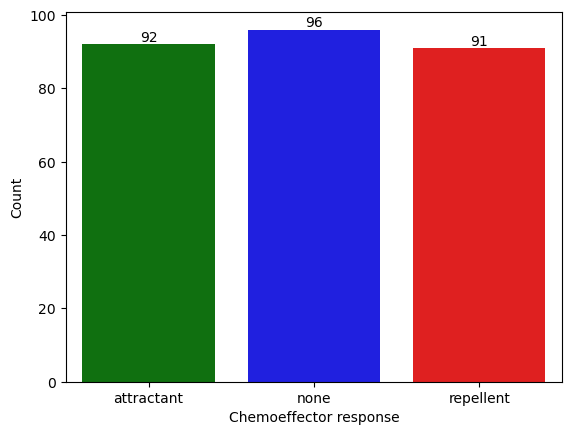

In [22]:
fig, ax = plt.subplots()
ax = sns.countplot(data=data, x='Response', hue='Response', legend=False, palette=['green','blue','red'], stat='count')
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlabel('Chemoeffector response')
ax.set_ylabel('Count')
plt.show()

Now let's get the fingerprints from the SMILES. <br>
We will ilustrate first with the first molecule from the data frame.

### Generating molecular fingerprint for each chemoeffectors using RDKit

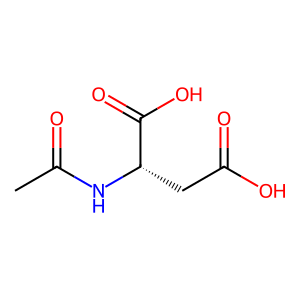

In [23]:
smile = data[smiles_column][0]
mol = Chem.MolFromSmiles(smile)
img = Draw.MolToImage(mol)
img

In [24]:
fingerprint = Chem.RDKFingerprint(mol, fpSize=nBits)
print(fingerprint)
fp = np.array(fingerprint)
print(fp)
print(len(fp))

[0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0
 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0
 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1
 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0
 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0
 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 1 1 1 0 0 0 0 0 0 0 

As we can see here, RDKFingerprint returns a vector of binary digit (0 or 1) to describes the molecule. 0 means the specific fragment is not found in the molecule and 1 means the fragment is found.

Now let's try with the second molecule:

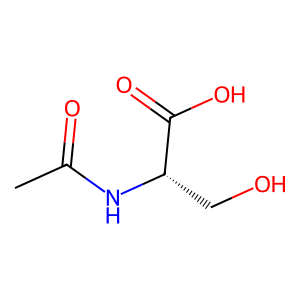

In [25]:
smile = data[smiles_column][1]
mol = Chem.MolFromSmiles(smile)
img = Draw.MolToImage(mol)
img

In [26]:
fingerprint = Chem.RDKFingerprint(mol, fpSize=nBits)
print(fingerprint)
fp = np.array(fingerprint)
print(fp)
print(len(fp))

[0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0
 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0
 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 

The RDKFingerprint has 2048 fragments as default, however we will only use 512 bits for the fragments as the other fingerprints (see below) have 512 bits as defaults. Therefore, 512 columns will be added to our dataframe. <br>
To generate the fingerprints, each SMILES needs to be translated into a RDKit molecule object.

,Chemoeffectors,Response,SMILES,Iso_SMILES,RDKit_Mol
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O,
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O,
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O,
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O,
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+],
...,...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN,
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O,
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O,
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O,

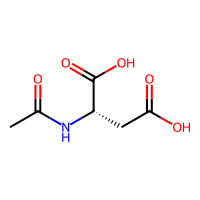
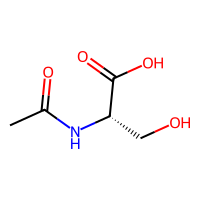
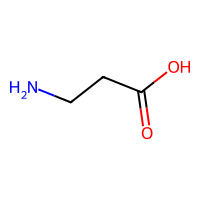
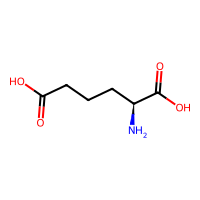
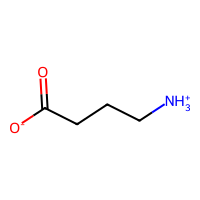
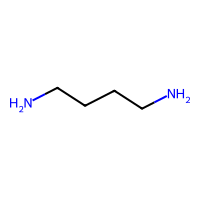
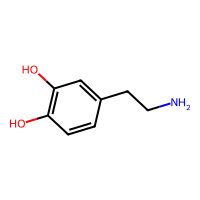
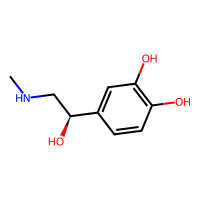
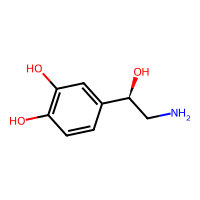
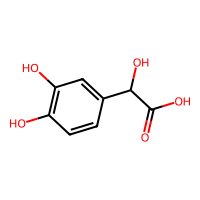

In [27]:
PandasTools.AddMoleculeColumnToFrame(data, 'Iso_SMILES', 'RDKit_Mol')
data

In [28]:
new_data = add_fingerprints(data, column='RDKit_Mol', fp_type='RDKit', nBits=nBits)
if save:
    new_data.to_csv('data/chemoeffectors_rdkit_fp.csv', index=False)
new_data

,Chemoeffectors,Response,SMILES,Iso_SMILES,RDKit_Mol,Fingerprint_0,Fingerprint_1,Fingerprint_2,Fingerprint_3,Fingerprint_4,...,Fingerprint_502,Fingerprint_503,Fingerprint_504,Fingerprint_505,Fingerprint_506,Fingerprint_507,Fingerprint_508,Fingerprint_509,Fingerprint_510,Fingerprint_511
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,1,0,...,0,0,0,0,1,1,1,1,0,1
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,1,1,1,1,0,1
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+],<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,1
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,1,1,0,0,...,1,0,0,0,0,1,1,0,0,1
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,1,1,0,0,...,1,0,0,0,0,1,1,0,0,1


This can also be done with another type of fingerprint:

In [29]:
#Atom-Pairs
data_atompairs = add_fingerprints(data, column='RDKit_Mol', fp_type='Atom-Pairs', nBits=nBits)
if save:
    data_atompairs.to_csv('data/chemoeffectors_atompairs_fp.csv', index=False)
data_atompairs

,Chemoeffectors,Response,SMILES,Iso_SMILES,RDKit_Mol,Fingerprint_0,Fingerprint_1,Fingerprint_2,Fingerprint_3,Fingerprint_4,...,Fingerprint_502,Fingerprint_503,Fingerprint_504,Fingerprint_505,Fingerprint_506,Fingerprint_507,Fingerprint_508,Fingerprint_509,Fingerprint_510,Fingerprint_511
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+],<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [30]:
#Topological-Torsions
data_topoltors = add_fingerprints(data, column='RDKit_Mol', fp_type='Topological-Torsions', nBits=nBits)
if save:
    data_topoltors.to_csv('data/chemoeffectors_topoltors_fp.csv', index=False)
data_topoltors

,Chemoeffectors,Response,SMILES,Iso_SMILES,RDKit_Mol,Fingerprint_0,Fingerprint_1,Fingerprint_2,Fingerprint_3,Fingerprint_4,...,Fingerprint_502,Fingerprint_503,Fingerprint_504,Fingerprint_505,Fingerprint_506,Fingerprint_507,Fingerprint_508,Fingerprint_509,Fingerprint_510,Fingerprint_511
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+],<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [31]:
#Morgan-Circular
data_morgancirc = add_fingerprints(data, column='RDKit_Mol', fp_type='Morgan-Circular', nBits=nBits)
if save:
    data_morgancirc.to_csv('data/chemoeffectors_morgancirc_fp.csv', index=False)
data_morgancirc

WARNING! Fingerprint type incorrect or undefined! Using defaults RDKit fingerprints...


,Chemoeffectors,Response,SMILES,Iso_SMILES,RDKit_Mol,Fingerprint_0,Fingerprint_1,Fingerprint_2,Fingerprint_3,Fingerprint_4,...,Fingerprint_502,Fingerprint_503,Fingerprint_504,Fingerprint_505,Fingerprint_506,Fingerprint_507,Fingerprint_508,Fingerprint_509,Fingerprint_510,Fingerprint_511
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,1,0,...,0,0,0,0,1,1,1,1,0,1
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,1,1,1,1,0,1
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+],<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,1
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,1,1,0,0,...,1,0,0,0,0,1,1,0,0,1
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,0,1,1,0,0,...,1,0,0,0,0,1,1,0,0,1


### Generating molecular descriptors for each chemoeffectors using RDKit

,Chemoeffectors,Response,SMILES,Iso_SMILES,RDKit_Mol
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O,
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O,
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O,
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O,
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+],
...,...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN,
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O,
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O,
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O,

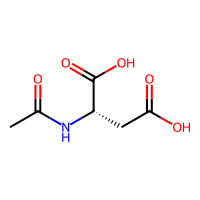
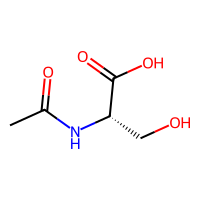
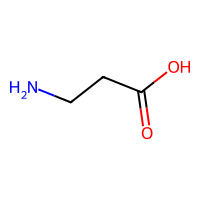
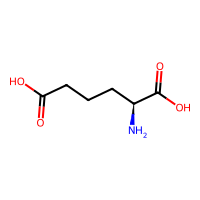
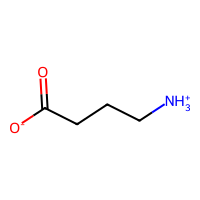
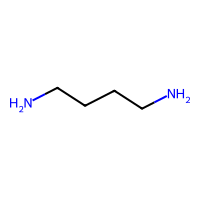
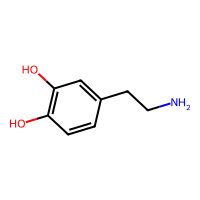
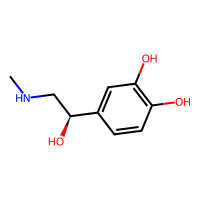
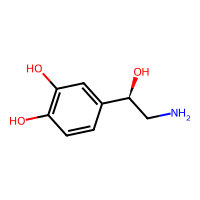
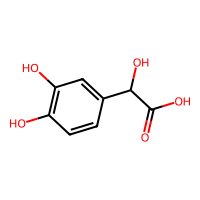

In [32]:
data

Let's look at the molecular descriptors for the first molecule.

In [33]:
d = Descriptors.CalcMolDescriptors(data['RDKit_Mol'][0])
print(d)
print(len(d))

{'MaxAbsEStateIndex': np.float64(10.372722978080121), 'MaxEStateIndex': np.float64(10.372722978080121), 'MinAbsEStateIndex': np.float64(0.5660648148148144), 'MinEStateIndex': np.float64(-1.354074074074074), 'qed': 0.5106757441982883, 'SPS': 11.75, 'MolWt': 175.14, 'HeavyAtomMolWt': 166.06799999999998, 'ExactMolWt': 175.048072388, 'NumValenceElectrons': 68, 'NumRadicalElectrons': 0, 'MaxPartialCharge': 0.32631125641394865, 'MinPartialCharge': -0.4811614657650901, 'MaxAbsPartialCharge': 0.4811614657650901, 'MinAbsPartialCharge': 0.32631125641394865, 'FpDensityMorgan1': 1.3333333333333333, 'FpDensityMorgan2': 1.8333333333333333, 'FpDensityMorgan3': 2.0833333333333335, 'BCUT2D_MWHI': 16.37512443581621, 'BCUT2D_MWLOW': 10.190299908980744, 'BCUT2D_CHGHI': 2.205728394475432, 'BCUT2D_CHGLO': -2.088966819646728, 'BCUT2D_LOGPHI': 1.9145760134277394, 'BCUT2D_LOGPLOW': -2.405401648556168, 'BCUT2D_MRHI': 5.852983883510826, 'BCUT2D_MRLOW': -0.1465996153967604, 'AvgIpc': 1.831371518279692, 'BalabanJ'

Now the 3D descriptors

In [34]:
mol3D = Chem.AddHs(data['RDKit_Mol'][0])
AllChem.EmbedMolecule(mol3D,randomSeed=0xf00d)
d = Descriptors3D.CalcMolDescriptors3D(mol3D)
print(d)
print(len(d))

{'PMI1': 517.9951416741569, 'PMI2': 652.5848943974986, 'PMI3': 945.8153995350154, 'NPR1': 0.5476704459758376, 'NPR2': 0.6899706800273333, 'RadiusOfGyration': 2.4580501405257524, 'InertialShapeFactor': 0.0013320022226412252, 'Eccentricity': 0.8366941392197195, 'Asphericity': 0.12820736473555094, 'SpherocityIndex': 0.3017940865941287, 'PBF': 0.6749334927998973}
11


As we can seem there are a lot more regular descriptors than 3D ones. <br>
Now, let's add the descriptors to our data frame.

In [35]:
data_d = add_descriptors(data, column='RDKit_Mol', add2D=True, add3D=False)
if save:
    data_d.to_csv('data/chemoeffectors_descriptors.csv', index=False)
data_d

,Chemoeffectors,Response,SMILES,Iso_SMILES,RDKit_Mol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,10.372723,10.372723,0.566065,-1.354074,0.510676,...,0,0,0,0,0,0,0,0,0,0
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,10.231944,10.231944,0.470880,-1.238241,0.456349,...,0,0,0,0,0,0,0,0,0,0
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,9.519306,9.519306,0.069444,-0.835648,0.475392,...,0,0,0,0,0,0,0,0,0,0
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,10.102570,10.102570,0.026806,-1.087603,0.511406,...,0,0,0,0,0,0,0,0,0,0
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+],<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,9.619306,9.619306,0.142361,-0.982731,0.438481,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,5.159028,5.159028,0.775000,0.775000,0.464599,...,0,0,0,0,0,0,0,0,1,0
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,9.035909,9.035909,0.087083,-0.091878,0.544873,...,0,0,0,0,0,0,0,0,0,0
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,9.480602,9.480602,0.180178,-0.669907,0.510157,...,0,0,0,0,0,0,0,0,0,0
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,9.226852,9.226852,0.087515,-0.794907,0.472427,...,0,0,0,0,0,0,0,0,0,0


In [36]:
check = data_d[data_d.isna().any(axis=1)]
check.loc[:, data_d.isna().any(axis=0)]

,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
229,1.0,-2.000000,2.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,2.0,-0.758769,2.0,0.758769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,2.0,-0.758769,2.0,0.758769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,2.0,-0.758769,2.0,0.758769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,1.0,-0.565179,1.0,0.565179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,1.0,-0.822417,1.0,0.822417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,1.0,-0.758769,1.0,0.758769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, the BCUT2D descriptors have a lot of NaN values. It is preferable to drop these inputs rather than losing some compounds.<br>
Moreover, three compounds have NaN values for the PartialCharge descriptors. It is reasonable to drop these three compounds rather than losing the partial charges as input.

In [37]:
data_3D = add_descriptors(data, column='RDKit_Mol', add2D=False, add3D=True)
if save:
    data_3D.to_csv('data/chemoeffectors_3Ddescriptors.csv', index=False)
data_3D

[17:19:07] UFFTYPER: Unrecognized charge state for atom: 0
[17:19:07] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[17:19:07] UFFTYPER: Unrecognized atom type: Ni3+2 (0)
[17:19:07] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[17:19:07] UFFTYPER: Unrecognized charge state for atom: 0
[17:19:07] UFFTYPER: Unrecognized atom type: Cr3+3 (1)
[17:19:07] UFFTYPER: Unrecognized atom type: Cu6+1 (1)
[17:19:07] UFFTYPER: Unrecognized atom type: Ni6+2 (1)


,Chemoeffectors,Response,SMILES,Iso_SMILES,RDKit_Mol,PMI1,PMI2,PMI3,NPR1,NPR2,RadiusOfGyration,InertialShapeFactor,Eccentricity,Asphericity,SpherocityIndex,PBF
0,N-acetyl-L-aspartate,attractant,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)N[C@@H](CC(=O)O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,517.995142,652.584894,945.815400,0.547670,0.689971,2.458050,0.001332,0.836694,0.128207,0.301794,0.674933
1,N-acetyl-L-serine,attractant,CC(=O)NC(CO)C(=O)O,CC(=O)N[C@@H](CO)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,300.179541,543.211526,707.817888,0.424091,0.767445,2.295988,0.002557,0.905619,0.209728,0.293030,0.637297
2,Beta-alanine,none,C(CN)C(=O)O,C(CN)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,63.327679,267.796122,301.915583,0.209753,0.886990,1.884847,0.014006,0.977754,0.498557,0.297762,0.487289
3,L-alpha-Aminoadipate,none,C(CC(C(=O)O)N)CC(=O)O,C(C[C@@H](C(=O)O)N)CC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,242.003185,1069.920774,1203.542292,0.201076,0.888976,2.793635,0.003673,0.979576,0.514529,0.226408,0.555617
4,gamma-amino-n-butyrate,none,C(CC(=O)[O-])C[NH3+],C(CC(=O)[O-])C[NH3+],<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,84.056191,403.482008,454.526816,0.184931,0.887697,2.137233,0.010561,0.982751,0.545106,0.334720,0.515294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,putrescine,none,C(CCN)CN,C(CCN)CN,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,33.456506,416.552975,435.524956,0.076819,0.956439,2.241128,0.028588,0.997045,0.787537,0.189280,0.479527
275,dopamine,attractant,C1=CC(=C(C=C1CCN)O)O,C1=CC(=C(C=C1CCN)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,188.661965,915.488778,1057.624368,0.178383,0.865609,2.656365,0.004588,0.983961,0.557886,0.144247,0.506588
276,epinephrine,none,CNCC(C1=CC(=C(C=C1)O)O)O,CNC[C@@H](C1=CC(=C(C=C1)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,300.266980,1250.669860,1489.273927,0.201620,0.839785,2.880486,0.002797,0.979464,0.513679,0.128863,0.503791
277,norepinephrine,repellent,C1=CC(=C(C=C1C(CN)O)O)O,C1=CC(=C(C=C1[C@H](CN)O)O)O,<rdkit.Chem.rdchem.Mol object at 0x000002B6C1D...,258.671995,939.575701,1035.897889,0.249708,0.907016,2.569604,0.003506,0.968321,0.431537,0.233567,0.578273


In that case, 3D descriptors are not really good candidates as ions are present in the data (nickel and cobalt are known repellent for E. coli, specific to Tar).

Now it is possible to built and train the model using different fingerprint and/or descriptors. <br>
That will be detailed in PART 2.